# Defining the scope of our simulation

## Context
In decentralized cloud computing environments, ensuring fair and efficient interactions is difficult due to limited visibility into the individual behavior of each actor involved in a task. Traditional mechanisms struggle to handle task failures effectively, because we usually don't know which actor is responsible for task failures. Therefore there is no way to incentivize good behaviour and reliability.

To solve this problem, we introduce "Blind Slashing," a penalty system that affects all parties involved in task failures, incentivizing better behavior and enhancing system reliability. This system is inspired by collective punishement and incentivize for cooperation. It is hoped that faulty actors will be engaged in more failed transactions, thus getting ruined out of the system.

## Core elements of the Simulation:  
A list of n actors, with each actor having:  
* An initial stake S0  

A list of faulty sets of actors, with each set having:  
* Between 1 and n actors.
* A probability of failure. 

## Task process

```
@startuml
title Task Execution Flow

start

:Pick a random set of 2 to n actors;

:Find all subsets of the chosen actors that exist in the faulty sets;

while (Faulty subsets remain?) is (Yes)
  :Check if the subset is triggering failure this execution\n(Draw x, a random number between 0 and 1 and\n compare it to the subset failure probability P_fail);
  
  if (N < P_fail?) then (Yes)
    :Task is a failure;
    :Slash all actors in the set;
    stop
  else (No)
    :Continue checking remaining subsets;
  endif
endwhile

:Task is a success;
:Reward all actors in the set;

stop
@enduml
```

## Simulation process

* We execute N number of tasks.
* Actors are removed from the system when their stake reach 0.
* New actors are added regularly, we also add them to the faulty set list, for each, we pick a random P_fail using normal distribution of fault probabilities.
* For each new actor we pick a random number of faulty combination and add them to the faulty set too, for those, we also pick a random P_fail using normal distribution of fault probabilities.

## Result to observe
* Average number of successed and failed task and ratio.
* Evolution of the number of user in the system and evolution of the average user failure rate.
* Global evolution of the system failure rate (average task failure rate).

## Code
### Importing libraries

In [54]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Defining constants

In [55]:
N_ACTORS_INITIAL = 100  # Initial number of actors
N_ACTORS_TASK = 4  # Number of maximum actors for each task
S0 = 1608  # Initial capital of each actor
N_TASKS = 2000  # Number of tasks to simulate
SLASH_AMOUNT = 400  # Amount slashed for failed tasks
REWARD_AMOUNT = 100  # Reward for successful tasks
NEW_ACTOR_INTERVAL = 50  # Frequency of new actor addition (in tasks)
NEW_ACTOR_FAULTY_COMBOS = 0  # Number of faulty combinations per new actor
NORMAL_DIST_MEAN = 0.3  # Mean of normal distribution for failure probability
NORMAL_DIST_STD = 0.5  # Standard deviation for failure probability
MONTE_CARLO_RUNS = 100  # Number of Monte Carlo simulations

### Testing different failure rate distribution

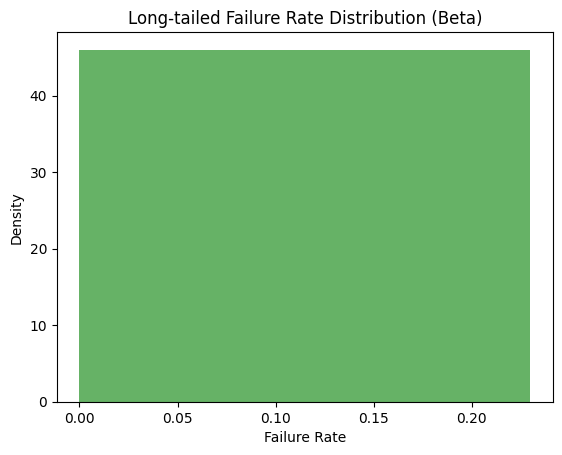

In [56]:
# Testing normal distribution --------------------------------------
# p_fail_distribution = np.random.lognormal(-2, 0.8, 10000)
# Testing continuous distribution ----------------------------------
# It seems that for a continuous distribution going from 0 to 0.3605 is the tipping point to ruining everyone
# This correspond to an average actor failure rate of 0.18025
# We notice that almost all actors are being evicted from the system at around task 600, until there is only 4 actors left. 
# It seems that if one of those actors is faulty, the system never recovers, but if we reach that point with only reliable actors, 
# then the system progressively recovers and then grows up to new highs.
p_fail_distribution = [i/10000.0 for i in range(2300)]
# Let's test that theory with another distribution giving the same average actor failure rate
# p_fail_distribution = [0 for _ in range(1000)] + [1 for _ in range(1500)]

# Plotting test distribution
plt.hist(p_fail_distribution, bins=50, density=False, alpha=0.6, color='g')
plt.title("Long-tailed Failure Rate Distribution (Beta)")
plt.xlabel("Failure Rate")
plt.ylabel("Density")
plt.show()

### Executing one simulation

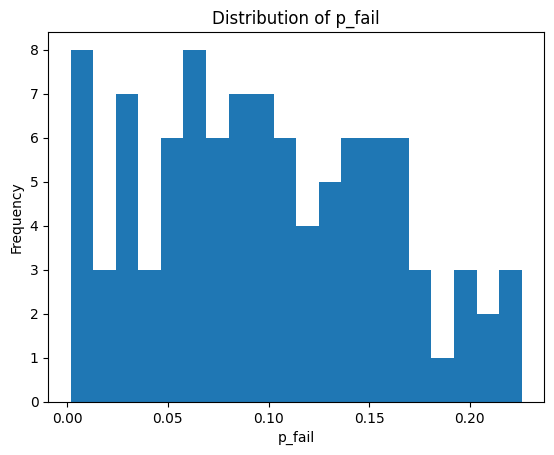

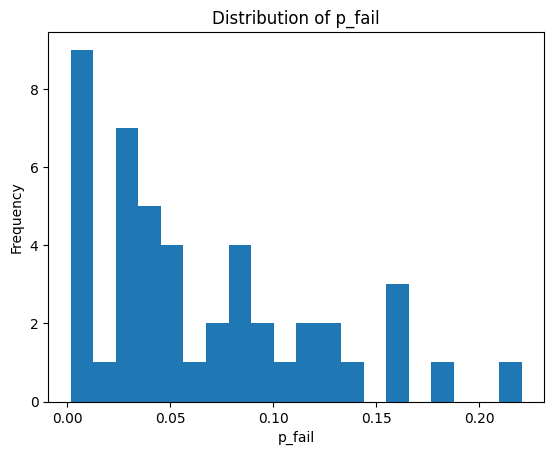

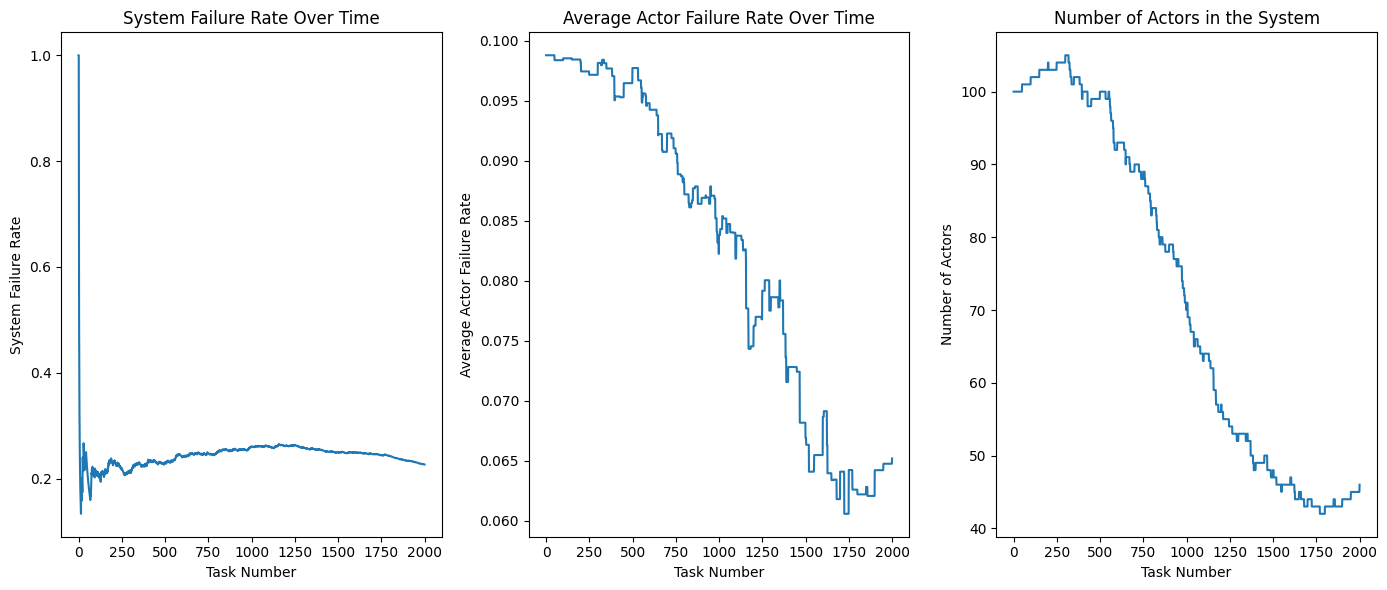

Failure rate target: 0.2
Individual failure rate target: 0.05425839099682417
Total successful tasks: 1547
Total failed tasks: 453
Total number of actors: 140
Final number of actors: 46

Classification Metrics:
Accuracy: 0.7857142857142857
Precision: 0.8936170212765957
Recall: 0.8076923076923077


In [57]:
# Initialize actors and faulty sets
class Actor:
    def __init__(self, id, stake):
        self.id = id
        self.stake = stake

class FaultySet:
    def __init__(self, actors, p_fail):
        self.actors = actors
        self.p_fail = p_fail

# Add an actor with a faulty set
def add_actor(actors, faulty_sets):
    # Add a new actor
    new_actor = Actor(len(actors), S0)
    actors.append(new_actor)

    # Generate a faulty set for the new actor
    faulty_set = FaultySet([new_actor], generate_p_fail())
    faulty_sets.append(faulty_set)
    
    # Generate faulty combinations sets for the new actor
    generate_faulty_combinations(new_actor, actors, faulty_sets)

# Generate initial faulty sets
def generate_faulty_combinations(actor, actors, faulty_sets):
    for _ in range(NEW_ACTOR_FAULTY_COMBOS):
        subset_size = random.randint(2, N_ACTORS_TASK-1)
        subset = random.sample(actors, subset_size)
        subset.append(actor)
        p_fail = generate_p_fail()
        faulty_sets.append(FaultySet(subset, p_fail))

# Generate p_fail based on long tail distribution
def generate_p_fail():
    # return max(0, min(1, np.random.normal(NORMAL_DIST_MEAN, NORMAL_DIST_STD)))
    return max(0, min(1, np.random.choice(p_fail_distribution)))

# Initialize actors and faulty sets
actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]
# Generate faulty combinations for the initial actors
for actor in actors:
    generate_faulty_combinations(actor, actors, faulty_sets)

# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Frequency')
plt.title('Distribution of p_fail')
plt.show()

# Calculate the failure rate target
failure_rate_target = REWARD_AMOUNT / (REWARD_AMOUNT + SLASH_AMOUNT)
indivudal_failure_rate_target = 1 - (1 - failure_rate_target) ** (1 / N_ACTORS_TASK)

# Calculate total number of actors that were added in the system
total_actors = N_ACTORS_INITIAL + N_TASKS // NEW_ACTOR_INTERVAL

# Task simulation
successful_tasks = 0
failed_tasks = 0

# Calculate precision, accuracy, and recall
true_positive = 0
false_positive = 0
false_negative = 0

system_failure_rates = []
actor_counts = []
average_failure_rates = []

for task_id in range(1, N_TASKS + 1):
    if len(actors) < 4:
        break
    
    # Pick a random subset of actors for the task
    task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
    
    # Check for faulty subsets within the chosen actors
    task_failed = False
    for faulty_set in faulty_sets:
        # Find if faulty set is a subset of task_actors
        if set(faulty_set.actors).issubset(task_actors):
            # Random chance to see if this faulty set triggers a failure
            if random.random() < faulty_set.p_fail:
                # Task failed, slash all actors involved
                task_failed = True
                failed_tasks += 1
                for actor in task_actors:
                    actor.stake -= SLASH_AMOUNT
                break

    if not task_failed:
        # Task succeeded, reward all actors involved
        successful_tasks += 1
        for actor in task_actors:
            actor.stake += REWARD_AMOUNT
    
    # Remove actors and corresponding faulty sets with zero or negative stake
    removed_actors = [actor for actor in actors if actor.stake <= 0]
    for actor in removed_actors:
        removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
        # print(f'Actor {actor.id}, p_fail {removed_failure_rate} has been removed')
        if removed_failure_rate[0] > indivudal_failure_rate_target:
            true_positive += 1
        else:
            false_positive += 1
        actors.remove(actor)
    faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

    # Every few tasks, add a new actor and corresponding faulty sets
    if task_id % NEW_ACTOR_INTERVAL == 0:
        add_actor(actors, faulty_sets)
    
    # Track system evolution metrics
    system_failure_rate = failed_tasks / task_id
    average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
    
    system_failure_rates.append(system_failure_rate)
    average_failure_rates.append(average_failure_rate)
    actor_counts.append(len(actors))


# Plot the distribution of p_fail
p_fail_values = [faulty_set.p_fail for faulty_set in faulty_sets]
plt.hist(p_fail_values, bins=20)
plt.xlabel('p_fail')
plt.ylabel('Frequency')
plt.title('Distribution of p_fail')
plt.show()

# Plot results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time
plt.subplot(1, 3, 1)
plt.plot(system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('System Failure Rate Over Time')

# Plot average actor failure rate over time
plt.subplot(1, 3, 2)
plt.plot(average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time')

# Plot the number of actors in the system over time
plt.subplot(1, 3, 3)
plt.plot(actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Number of Actors in the System')

plt.tight_layout()
plt.show()

# Final results
print(f'Failure rate target: {failure_rate_target}')
print(f'Individual failure rate target: {indivudal_failure_rate_target}')
print(f'Total successful tasks: {successful_tasks}')
print(f'Total failed tasks: {failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Final number of actors: {len(actors)}')

# Calculate precision, accuracy, and recall
for faulty_set in faulty_sets:
    if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
        false_negative += 1

precision = true_positive / (true_positive + false_positive)
accuracy = (true_positive + (len(actors) - false_negative)) / total_actors
recall = 0
if true_positive + false_negative != 0:
    recall = true_positive / (true_positive + false_negative)
# Display precision, accuracy, and recall
print("\nClassification Metrics:")
# Part of all the elements that was right
print(f'Accuracy: {accuracy}')
# Part of what we predicted that is good
print(f'Precision: {precision}')
# Part of the relevant elements that we predicted
print(f'Recall: {recall}')

### Executing several simulations (Monte Carlo)

To implement a Monte Carlo simulation, we need to run the same simulation multiple times and aggregate the results. This will give us a broader view of how the system behaves across different random scenarios. I'll modify the code to add a Monte Carlo loop, store the outcomes of each simulation, and then calculate the average metrics across all simulations.

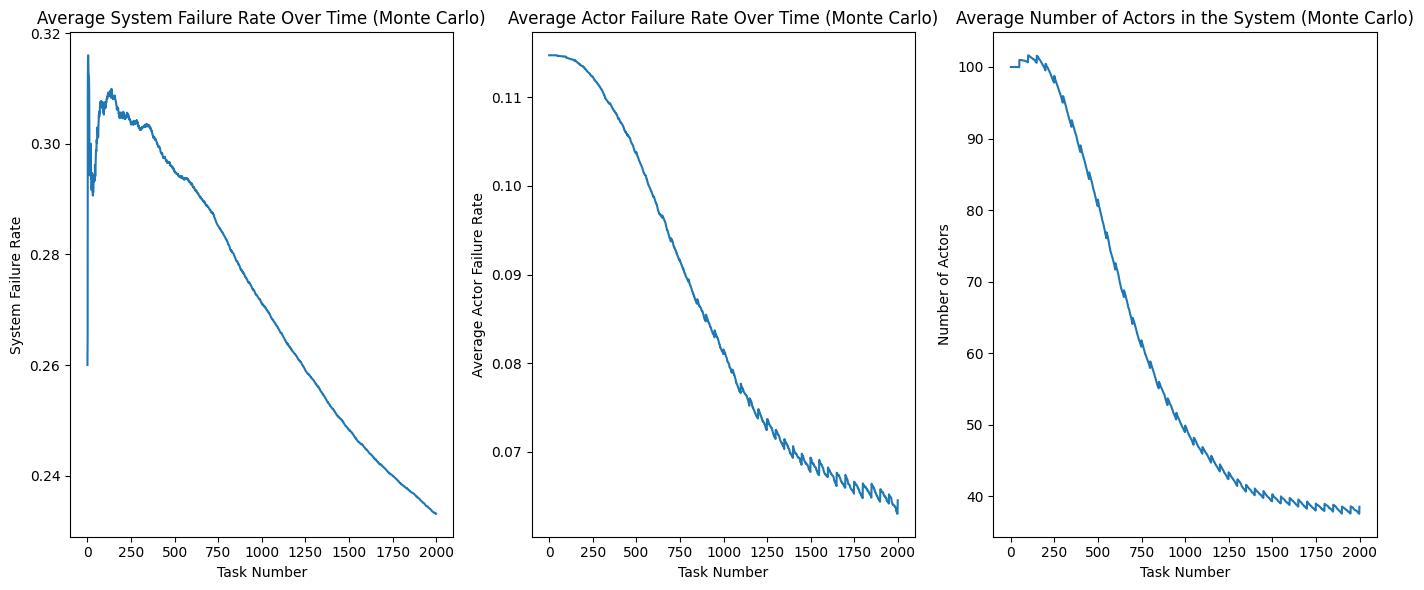

Average total successful tasks: 1533.8
Average total failed tasks: 466.2
Total number of actors: 140
Average final number of actors: 38.55
Uncompleted simulations: 0/100

Classification Metrics (Averaged over Monte Carlo runs):
Average Precision: 0.8690835570270867
Average Accuracy: 0.7733571428571427
Average Recall: 0.8254499470895793


In [58]:
# Monte Carlo results storage
monte_carlo_results = {
    'system_failure_rates': [],
    'average_failure_rates': [],
    'actor_counts': [],
    'final_successful_tasks': [],
    'final_failed_tasks': [],
    'final_number_of_actors': [],
    'precisions': [],
    'accuracies': [],
    'recalls': []
}

# Function to pad a list with zeros up to a target length
def pad_list_with_zeros(lst, target_length):
    return lst + [0] * (target_length - len(lst))

# Function extend list to desired length by repeatinig the last element
def extend_list(lst, target_length):
    return lst + [lst[-1]] * (target_length - len(lst))

# Function to run a single simulation
def run_simulation():
    # Initialize actors and faulty sets
    actors = [Actor(i, S0) for i in range(N_ACTORS_INITIAL)]
    faulty_sets = [FaultySet([actor], generate_p_fail()) for actor in actors]

    # Generate faulty combinations for the initial actors
    for actor in actors:
        generate_faulty_combinations(actor, actors, faulty_sets)

    successful_tasks = 0
    failed_tasks = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0

    system_failure_rates = []
    actor_counts = []
    average_failure_rates = []

    # Task simulation loop
    for task_id in range(1, N_TASKS + 1):
        if len(actors) < 4:
            break
        
        # Pick a random subset of actors for the task
        task_actors = random.sample(actors, random.randint(2, N_ACTORS_TASK))
        
        # Check for faulty subsets within the chosen actors
        task_failed = False
        for faulty_set in faulty_sets:
            # Find if faulty set is a subset of task_actors
            if set(faulty_set.actors).issubset(task_actors):
                # Random chance to see if this faulty set triggers a failure
                if random.random() < faulty_set.p_fail:
                    # Task failed, slash all actors involved
                    task_failed = True
                    failed_tasks += 1
                    for actor in task_actors:
                        actor.stake -= SLASH_AMOUNT
                    break

        if not task_failed:
            # Task succeeded, reward all actors involved
            successful_tasks += 1
            for actor in task_actors:
                actor.stake += REWARD_AMOUNT
        
        # Remove actors and corresponding faulty sets with zero or negative stake
        removed_actors = [actor for actor in actors if actor.stake <= 0]
        for actor in removed_actors:
            removed_failure_rate = [fs.p_fail for fs in faulty_sets if actor in fs.actors and len(fs.actors) == 1]
            if removed_failure_rate and removed_failure_rate[0] > indivudal_failure_rate_target:
                true_positive += 1
            else:
                false_positive += 1
            actors.remove(actor)
        faulty_sets = [fs for fs in faulty_sets if all(actor in actors for actor in fs.actors)]

        # Every few tasks, add a new actor and corresponding faulty sets
        if task_id % NEW_ACTOR_INTERVAL == 0:
            add_actor(actors, faulty_sets)
        
        # Track system evolution metrics
        system_failure_rate = failed_tasks / task_id
        average_failure_rate = np.mean([fs.p_fail for fs in faulty_sets])
        
        system_failure_rates.append(system_failure_rate)
        average_failure_rates.append(average_failure_rate)
        actor_counts.append(len(actors))
    
    # Calculate precision, accuracy, and recall
    for faulty_set in faulty_sets:
        if len(faulty_set.actors) == 1 and faulty_set.p_fail > indivudal_failure_rate_target:
            false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    accuracy = (true_positive + (len(actors) - false_negative)) / total_actors if total_actors > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    return {
        'system_failure_rates': system_failure_rates,
        'average_failure_rates': average_failure_rates,
        'actor_counts': actor_counts,
        'successful_tasks': successful_tasks,
        'failed_tasks': failed_tasks,
        'final_number_of_actors': len(actors),
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall
    }

# Run Monte Carlo simulations
for i in range(MONTE_CARLO_RUNS):
    result = run_simulation()
    monte_carlo_results['system_failure_rates'].append(result['system_failure_rates'])
    monte_carlo_results['average_failure_rates'].append(result['average_failure_rates'])
    monte_carlo_results['actor_counts'].append(result['actor_counts'])
    monte_carlo_results['final_successful_tasks'].append(result['successful_tasks'])
    monte_carlo_results['final_failed_tasks'].append(result['failed_tasks'])
    monte_carlo_results['final_number_of_actors'].append(result['final_number_of_actors'])
    monte_carlo_results['precisions'].append(result['precision'])
    monte_carlo_results['accuracies'].append(result['accuracy'])
    monte_carlo_results['recalls'].append(result['recall'])

# Count the number of uncompleted simulations
uncompleted_simulations = 0
for i in range(MONTE_CARLO_RUNS):
    if len(monte_carlo_results['system_failure_rates'][i]) < N_TASKS:
        uncompleted_simulations += 1

# Pad the lists with zeros to the maximum length
padded_system_failure_rates = [extend_list(run, N_TASKS) for run in monte_carlo_results['system_failure_rates']]
padded_average_failure_rates = [extend_list(run, N_TASKS) for run in monte_carlo_results['average_failure_rates']]
padded_actor_counts = [extend_list(run, N_TASKS) for run in monte_carlo_results['actor_counts']]

# Aggregate the results
avg_system_failure_rates = np.mean(padded_system_failure_rates, axis=0)
avg_average_failure_rates = np.mean(padded_average_failure_rates, axis=0)
avg_actor_counts = np.mean(padded_actor_counts, axis=0)

avg_final_successful_tasks = np.mean(monte_carlo_results['final_successful_tasks'])
avg_final_failed_tasks = np.mean(monte_carlo_results['final_failed_tasks'])
avg_final_number_of_actors = np.mean(monte_carlo_results['final_number_of_actors'])
avg_precision = np.mean(monte_carlo_results['precisions'])
avg_accuracy = np.mean(monte_carlo_results['accuracies'])
avg_recall = np.mean(monte_carlo_results['recalls'])

# Plot aggregated results
plt.figure(figsize=(14, 6))

# Plot system failure rate over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 1)
plt.plot(avg_system_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('System Failure Rate')
plt.title('Average System Failure Rate Over Time (Monte Carlo)')

# Plot average actor failure rate over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 2)
plt.plot(avg_average_failure_rates)
plt.xlabel('Task Number')
plt.ylabel('Average Actor Failure Rate')
plt.title('Average Actor Failure Rate Over Time (Monte Carlo)')

# Plot the number of actors in the system over time (averaged over Monte Carlo runs)
plt.subplot(1, 3, 3)
plt.plot(avg_actor_counts)
plt.xlabel('Task Number')
plt.ylabel('Number of Actors')
plt.title('Average Number of Actors in the System (Monte Carlo)')

plt.tight_layout()
plt.show()

# Final results
print(f'Average total successful tasks: {avg_final_successful_tasks}')
print(f'Average total failed tasks: {avg_final_failed_tasks}')
print(f'Total number of actors: {total_actors}')
print(f'Average final number of actors: {avg_final_number_of_actors}')
print(f'Uncompleted simulations: {uncompleted_simulations}/{MONTE_CARLO_RUNS}')

# Display precision, accuracy, and recall
print("\nClassification Metrics (Averaged over Monte Carlo runs):")
print(f'Average Precision: {avg_precision}')
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Recall: {avg_recall}')

# Add the ratio of failed tasks to the total number of tasks
# Find which average failure rate gives the best metrics